In [ ]:
# Importando Bibliotecas
import pandas as pd
from scipy.stats import zscore
from AnalysisUtils import *
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.impute import KNNImputer

In [ ]:
def encode_string_columns(df):
  # Select columns of type 'object' or 'category'
  non_numeric_columns = df.select_dtypes(include=['object', 'category'])

  for col in non_numeric_columns.columns:
    # Get the unique values in the column
    unique_values = df[col].dropna().unique()
    
    if col == 'come_entre_refeicoes':
      df['dummy_come_entre_refeicoes'] = df[col].str.lower().map({'nao':0, 'as vezes':1, 'frequentemente':2, 'sempre': 3})
      continue
      
    if col == 'consumo_alcool':
      df['dummy_come_entre_refeicoes'] = df[col].str.lower().map({'nao':0, 'as vezes':1, 'frequentemente':2})
      continue

    if df[col].str.lower().isin(['sim', 'nao']).all():
      df[f"dummy_{col}"] = df[col].str.lower().map({'sim': 1, 'nao': 0})
      continue
      
    if len(unique_values) == 2:
      label_encoder = LabelEncoder()
      df[f"dummy_{col}"] = label_encoder.fit_transform(df[col])
      continue
    else:
      df_dummies = pd.get_dummies(df[col], prefix=f"dummy_{col}")
      df = pd.concat([df, df_dummies], axis=1)
      continue
        
  return df

def fill_missing_data(df, method='simple', n_neighbors=5):
  if method == 'simple':
    for col in df.columns:
      if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].mean())
      else:
        if df[col].notna().any():
          df[col] = df[col].fillna(df[col].mode()[0])

  elif method == 'knn':
    # Separate numeric and non-numeric columns
    df_numeric = df.select_dtypes(include=['float64', 'int64'])
    df_non_numeric = df.select_dtypes(exclude=['float64', 'int64'])

    # Apply get_dummies for non-numeric columns to perform one-hot encoding
    df_non_numeric_dummies = pd.get_dummies(df_non_numeric, drop_first=False)

    # Impute using KNN
    imputer_numeric = KNNImputer(n_neighbors=n_neighbors)
    imputer_non_numeric = KNNImputer(n_neighbors=1)
    
    df_imputed_numeric = pd.DataFrame(
      imputer_numeric.fit_transform(df_numeric),
      columns=df_numeric.columns,
      index=df_numeric.index
    )

    df_imputed_non_numeric = pd.DataFrame(
      imputer_non_numeric.fit_transform(df_non_numeric_dummies),
      columns=df_non_numeric_dummies.columns,
      index=df_non_numeric_dummies.index
    )
    # Reverse the one-hot encoding by getting the most frequent category for each column
    df_non_numeric_imputed = pd.DataFrame(index=df_imputed_non_numeric.index)
    for col in df_non_numeric.columns:
      vals_col = df_non_numeric[col].dropna().unique()
      
      dummies = [col + '_' + str(val) for val in vals_col]
      dummies_values = df_imputed_non_numeric[dummies].idxmax(axis=1).apply(lambda x: x.split('_')[-1])
      df_non_numeric_imputed[col] = dummies_values

    # Combine numeric and non-numeric back to the original DataFrame
    df = pd.concat([df_imputed_numeric, df_non_numeric_imputed], axis=1)

  else:
    raise ValueError("Invalid method. Choose from 'simple' or 'knn'.")

  return df

def detect_outliers(df):
  z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
  outliers = z_scores > 3  # Consider values with Z-score greater than 3 as outliers
  return outliers.sum()

def analyze_numerical_column(row):
  print_simple_metrics(row)
  boxplot_with_quartiles(row, yscale='linear')
  create_filtered_histograms(row, log=False, filters=None, color='blue', bins=100)

def calculate_group_metric(df, category_columns, numerical_columns, metric='median'):
  result_list = []

  for i in range(len(category_columns)):
    for value in df[category_columns[i]].unique():
      group_df = df[df[category_columns[i]] == value]

      if metric == 'median':
        group_metric = group_df[numerical_columns].median()
      else:
        group_metric = group_df[numerical_columns].mean()

      group_metric['category'] = f"{category_columns[i]}: {value}"
      result_list.append(group_metric)

  result_df = pd.DataFrame(result_list)

  return result_df

def plot_sorted_group_metric(result_df, numerical_columns, metric='median'):
  for col in numerical_columns:
    # Sort the result DataFrame by the median of the current column
    sorted_df = result_df.set_index('category').sort_values(by=col).reset_index()

    # Create a new figure for each numerical column
    plt.figure(figsize=(12, 8))

    # Prepare the boxplot data by creating a new DataFrame with the sorted categories
    sorted_categories = sorted_df['category'].values
    boxplot_data = []

    for category in sorted_categories:
      # Create the boxplot data by selecting the group corresponding to each category
      group_category = category.split(":")[0]  # Extract the category name from 'column: value'
      group_value = category.split(":")[1].strip()  # Extract the value
      group_df = df[df[group_category] == group_value]  # Get the subgroup
      boxplot_data.append(group_df[col].values)

    # Create the boxplot, aligned by the sorted categories
    sns.boxplot(data=boxplot_data, order=range(len(sorted_categories)))

    # Set labels and title for the plot
    plt.xticks(range(len(sorted_categories)), sorted_categories, rotation=45, ha='right')
    plt.xlabel('Category')
    plt.ylabel(f'{metric} of {col}')
    plt.title(f'Sorted {metric}s of {col} by Category')
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_all_category_columns(df, category_columns, color='skyblue', top=10):
  num_columns = len(category_columns)
  rows = (num_columns // 3) + (num_columns % 3 > 0)

  fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
  axes = axes.flatten()

  for idx, column in enumerate(category_columns):
    ax = axes[idx]

    # Get the value counts for the encoded column
    result_df = df[column].value_counts().reset_index()
    result_df.columns = [column, 'Count']
    result_df['Percentage'] = (result_df['Count'] / result_df['Count'].sum()) * 100

    # Keep only top N values if specified
    result_df = result_df.head(top)

    # Plot the bar chart
    result_df.plot(kind='bar', x=column, y='Count', color=color, ax=ax, legend=False)

    ax.set_title(f"Value Counts of {column}", fontsize=12, pad=20)
    ax.set_xlabel('Values', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.tick_params(axis='x', rotation=45)

    for i, (count, pct) in enumerate(zip(result_df['Count'], result_df['Percentage'])):
      ax.text(i, count + 0.5, f'{count} / {pct:.1f}%', ha='center', va='bottom')

  # Remove any empty axes
  for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

  plt.subplots_adjust(hspace=0.5, wspace=0.3)
  plt.tight_layout()
  plt.show()

def scale_data(df, columns):
  scaler = StandardScaler()
  df[columns] = scaler.fit_transform(df[columns])
  return df

def scale_and_prepare_data(df, categorical_columns, numerical_columns):
  # One-hot encode categorical columns
  df_dummies = pd.get_dummies(df[categorical_columns], drop_first=True)

  # Initialize StandardScaler
  scaler = StandardScaler()

  # Scale the specified numerical columns
  df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

  # Scale the one-hot encoded categorical columns (df_dummies)
  df_dummies_scaled = scaler.fit_transform(df_dummies)

  # Convert the scaled dummies back to a DataFrame and assign correct column names manually
  df_dummies_scaled = pd.DataFrame(df_dummies_scaled, columns=df_dummies.columns, index=df.index)

  # Concatenate the scaled numerical columns with the scaled one-hot encoded columns
  df = pd.concat([df[numerical_columns], df_dummies_scaled], axis=1)

  return df

def add_health_columns(df):
    # Calcular IMC
    df['IMC'] = df['peso'] / (df['altura'] ** 2)

    # Classificar IMG
    def classify_imc(img):
        if img <= 18.5:
            return 'Baixo'
        elif img <= 24.9:
            return 'Normal'
        elif img <= 29.9:
            return 'Sobrepeso'
        else:
            return 'Obesidade'

    df['Class_IMC'] = df['IMC'].apply(classify_imc)

    return df

def plot_and_return_correlation(df, category_columns_dummies, numeric_columns, method='spearman', plot=True):

  df_numeric = df[numeric_columns + category_columns_dummies]

  correlation_matrix = df_numeric.corr(method=method)

  # Plot the heatmap
  if plot:
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlação ({method.capitalize()})')
    plt.show()

  # Flatten the correlation matrix and sort by absolute value
  corr_pairs = correlation_matrix.unstack()
  sorted_corr = corr_pairs.sort_values(key=lambda x: x.abs(), ascending=False)

  # Exclude self-correlations
  filtered_corr = sorted_corr[sorted_corr.index.get_level_values(0) != sorted_corr.index.get_level_values(1)]

  # Remove duplicates like [A, B] and [B, A]
  unique_pairs = filtered_corr.reset_index()
  unique_pairs['sorted_index'] = unique_pairs.apply(lambda row: tuple(sorted([row['level_0'], row['level_1']])), axis=1)
  unique_pairs = unique_pairs.drop_duplicates(subset='sorted_index').drop(columns='sorted_index')

  # Rename columns for clarity
  unique_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

  return unique_pairs, correlation_matrix

def show_changed_missing_values(df1, df2):

  df1_ordered = df1[df2.columns]
  changed = df1_ordered != df2
  changed_rows_df1 = df1_ordered[changed].dropna(how='all')
  changed_rows_df2 = df2[changed].dropna(how='all')

  merged_values = changed_rows_df1.combine(
    changed_rows_df2,
    lambda x1, x2: pd.Series([f"{v1} | {v2}" if pd.notna(v1) and pd.notna(v2) else None for v1, v2 in zip(x1, x2)])
  )

  return merged_values

def pca_analysis(df, columns, plot=True):
  # Performing PCA
  pca_df = df[columns].copy()
  pca = PCA()
  pca_data = pca.fit_transform(pca_df)
  for i in range(pca_data.shape[1]):
    pca_df[f'pca{i+1}'] = pca_data[:, i]

  # Loading components
  loadings = pd.DataFrame(
    pca.components_,
    columns=pca_df.columns[:pca.components_.shape[-1]],
    index=[f'PCA{i + 1}' for i in range(pca.n_components_)]
  )

  # Explained variance ratio and PCA contributions
  explained_variance_ratio = pca.explained_variance_ratio_
  pca_contributions = (explained_variance_ratio[:5]).round(4)
  
  if plot:
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_df['pca1'], pca_df['pca2'], s=50)
    plt.title("PCA Clustering")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

  sorted_loadings = {}
  for i in range(pca.n_components_):
    pca_component = f'PCA{i + 1}'
    top_contributors = loadings.iloc[i].abs().sort_values(ascending=False).head(5)

    # Create a dictionary for the top contributors and their contributions
    sorted_loadings[pca_component] = {
      feature: top_contributors[feature] for feature in top_contributors.index
    }

  return pca_df, sorted_loadings, pca_contributions

def pca_explained_variance_plot(df, columns):
  pca_df = df[columns].copy()
  pca = PCA()
  pca_data = pca.fit_transform(pca_df)
  explained_variance_ratio = pca.explained_variance_ratio_
  cumulative_explained_variance = explained_variance_ratio.cumsum()

  # Plot the cumulative explained variance vs the number of principal components
  plt.figure(figsize=(8, 6))
  plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
  plt.title("Cumulative Explained Variance vs. Number of Principal Components")
  plt.xlabel("Number of Principal Components")
  plt.ylabel("Cumulative Explained Variance (%)")
  plt.xticks(range(1, len(explained_variance_ratio) + 1))
  plt.yticks([i / 10 for i in range(0, 11)])
  plt.grid(True)
  plt.show()

  # Now, let's calculate and plot the contribution of each original column to the total variance explained
  loadings = pd.DataFrame(
    pca.components_,
    columns=pca_df.columns[:pca.components_.shape[-1]],
    index=[f'PCA{i + 1}' for i in range(pca.n_components_)]
  )
  
  # Calculate the contribution of each original feature across all principal components
  feature_contributions = loadings.abs().sum(axis=0).sort_values(ascending=False)
  
  plt.figure(figsize=(12, 8))  # Set larger figure size
  feature_contributions.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 8))
  plt.title("Feature Contribution to PCA Components", fontsize=16, fontweight='bold')
  plt.xlabel("Original Features", fontsize=12)
  plt.ylabel("Total Contribution to PCA Components", fontsize=12)
  plt.xticks(rotation=45, ha='right', fontsize=10)
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()
  plt.show()

  return cumulative_explained_variance, feature_contributions


In [ ]:
numerical_columns = ['idade', 'idade_int', 'altura', 'peso', 'consome_vegetais', 'consome_vegetais_int', 'n_refeicoes_int', 'consumo_diario_agua', 'consumo_diario_agua_int', 'frequencia_atividade_fisica', 'frequencia_atividade_fisica_int', 'tempo_usando_eletronicos', 'tempo_usando_eletronicos_int', 'IMC']

category_columns = ['sexo', 'historico_obesidade_familia', 'consome_comida_calorica', 'come_entre_refeicoes', 'fuma', 'consumo_alcool', 'tipo_transporte', 'Class_IMC', 'tipo_transporte_adaptado']

category_columns_dummies = [
  'dummy_sexo',
  'dummy_historico_obesidade_familia',
  'dummy_consome_comida_calorica',
  'dummy_come_entre_refeicoes',
  'dummy_fuma',
  'dummy_tipo_transporte_adaptado_ativo',
  'dummy_tipo_transporte_adaptado_individual',
  'dummy_tipo_transporte_adaptado_transporte publico'
]

In [573]:
df.columns

Index(['idade', 'altura', 'peso', 'consome_vegetais', 'n_refeicoes',
       'consumo_diario_agua', 'frequencia_atividade_fisica',
       'tempo_usando_eletronicos', 'sexo', 'historico_obesidade_familia',
       'consome_comida_calorica', 'come_entre_refeicoes', 'fuma',
       'consumo_alcool', 'tipo_transporte', 'idade_int', 'n_refeicoes_int',
       'consome_vegetais_int', 'consumo_diario_agua_int',
       'frequencia_atividade_fisica_int', 'tempo_usando_eletronicos_int',
       'tipo_transporte_adaptado', 'IMC', 'Class_IMC', 'dummy_sexo',
       'dummy_historico_obesidade_familia', 'dummy_consome_comida_calorica',
       'dummy_come_entre_refeicoes', 'dummy_fuma',
       'dummy_tipo_transporte_andando', 'dummy_tipo_transporte_bicicleta',
       'dummy_tipo_transporte_carro', 'dummy_tipo_transporte_moto',
       'dummy_tipo_transporte_transporte publico',
       'dummy_tipo_transporte_adaptado_ativo',
       'dummy_tipo_transporte_adaptado_individual',
       'dummy_tipo_transporte_ad

# Comparação de estratégias de inputting

In [ ]:
df_test = pd.read_csv('data/trabalho2_dados_4.csv')
missing_rows_idx = df_test[df_test.isna().any(axis=1)].index.tolist()

df_test_knn = fill_missing_data(df_test, method='knn')
df_test_simple = fill_missing_data(df_test, method='simple')

show_changed_missing_values(df_test_knn, df_test_simple)

## buscando duplicada nova gerada com inputting (gerou para ambos)
ele tinha transporte publico como NaN, mas ao substiruí-lo virou uma duplicada perfeita.

In [ ]:
# analisando duplicata nova gerada pelo fill_missing_data
df_test = pd.read_csv('data/trabalho2_dados_4.csv')

print('Antes do Input')
new_duplicate = df_test.loc[602].copy()
display(df_test[df_test.eq(df_test.loc[1]).all(axis=1)])

df_test = fill_missing_data(df_test) 

print('Depois do Input')
display(df_test.loc[602])
display(df_test[df_test.eq(df_test.loc[1]).all(axis=1)])
new_duplicate

## Pre processando Dados

In [ ]:
# Importando dados
df = pd.read_csv('data/trabalho2_dados_4.csv')
df = fill_missing_data(df, method='knn') # substituindo valores faltantes numéricos pela media e categóricos pela moda


df['idade_int'] = np.floor(df['idade'])
df['n_refeicoes_int'] = df['n_refeicoes'].round()
df['consome_vegetais_int'] = df['consome_vegetais'].round()
df['consumo_diario_agua_int'] = df['consumo_diario_agua'].round()
df['frequencia_atividade_fisica_int'] = df['frequencia_atividade_fisica'].round()
df['tempo_usando_eletronicos_int'] = df['tempo_usando_eletronicos'].round()

df['tipo_transporte_adaptado'] = df['tipo_transporte'].apply(
  lambda x: 'ativo' if x in ['bicicleta', 'andando'] else 'individual' if x in ['carro', 'moto'] else x)

df = add_health_columns(df)
df = encode_string_columns(df) # encodando colunas de string
df = df.drop_duplicates(df, keep='first') # remoção de ~250 entradas duplicadas (substituição de valores faltantes e transformação direta em int nao criaram novas duplicados apenas 1 para o caso de substituição
df.columns

## Detecção de outliers

In [ ]:
detect_outliers(df) 
# Não foram detectados outliers relevantes nas métricas numéricas
# a unica metrica com outliers usando z_score foi a de idade, mas essa distribuição não é normal, e foram apenas 7 encontrados
# nas métricas categóricas, isso removeria certas do categorias do dataset, portanto, não é necessário remover outliers neste dataset

## Análises simples

In [ ]:
plot_all_category_columns(df, category_columns, color='skyblue', top=10)

In [ ]:
for row in numerical_columns:
  analyze_numerical_column(df[row]) 

## Gráficos categorias 

In [ ]:
result_df = calculate_group_metric(df, category_columns, numerical_columns, metric='mean')
plot_sorted_group_metric(result_df, numerical_columns, metric='mean')

## Análise de correlação com spearmann

In [ ]:
sorted_corr, corr_matrix = plot_and_return_correlation(df, category_columns_dummies=category_columns_dummies, numeric_columns=['idade_int', 'altura', 'peso', 'consome_vegetais_int', 'n_refeicoes_int', 'consumo_diario_agua_int', 'frequencia_atividade_fisica_int', 'tempo_usando_eletronicos_int', 'IMC'], method='spearman')
sorted_corr

# analise de influencia de colunas int para correlação

In [ ]:
sorted_corr, corr_matrix = plot_and_return_correlation(df, category_columns_dummies=category_columns_dummies,
                            numeric_columns=['idade_int', 'consome_vegetais_int', 'n_refeicoes_int',
                                             'consumo_diario_agua_int', 'frequencia_atividade_fisica_int',
                                             'tempo_usando_eletronicos_int'], method='spearman', plot=False)

sorted_corr2, corr_matrix2 = plot_and_return_correlation(df, category_columns_dummies=category_columns_dummies,
                                                       numeric_columns=['idade', 'consome_vegetais', 'n_refeicoes', 'consumo_diario_agua','frequencia_atividade_fisica', 'tempo_usando_eletronicos'],
                                                       method='spearman', plot=False)


diff = abs(corr_matrix.to_numpy()) - abs(corr_matrix2.to_numpy())
mask1 = (abs(corr_matrix.to_numpy()) >= 0.3) & (diff > 0)
plt.figure(figsize=(8, 6))
sns.heatmap(mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'int vs sem int  (diff>0)')
plt.show()


mask2 = (abs(corr_matrix.to_numpy()) >= 0.3) & (diff < 0)
plt.figure(figsize=(8, 6))
sns.heatmap(mask2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'int vs sem int (diff<0)')
plt.show()


# começando analises para agrupamento

In [578]:
numerical_columns_clustering_refinado = ['idade_int', 'consome_vegetais_int', 'n_refeicoes_int', 'consumo_diario_agua_int', 'frequencia_atividade_fisica_int', 'IMC'] 
numerical_columns_clustering = ['idade', 'consome_vegetais', 'n_refeicoes', 'consumo_diario_agua', 'frequencia_atividade_fisica', 'tempo_usando_eletronicos', 'IMC', 'peso', 'altura']

category_columns_clustering_refinado = [
  'dummy_sexo',
  'dummy_historico_obesidade_familia',
  'dummy_consome_comida_calorica',
  'dummy_come_entre_refeicoes',
  'dummy_fuma',
  'dummy_tipo_transporte_adaptado_ativo',
  'dummy_tipo_transporte_adaptado_individual',
  'dummy_tipo_transporte_adaptado_transporte publico'
]

category_columns_clustering = [
  'dummy_sexo',
  'dummy_historico_obesidade_familia',
  'dummy_consome_comida_calorica',
  'dummy_come_entre_refeicoes',
  'dummy_fuma',
  'dummy_tipo_transporte_andando', 
  'dummy_tipo_transporte_bicicleta',
  'dummy_tipo_transporte_carro', 
  'dummy_tipo_transporte_moto',
  'dummy_tipo_transporte_transporte publico'
]

print(f"dimensionalidade: {len(numerical_columns_clustering + category_columns_clustering)}")

scaled_df = scale_data(df, list(set(numerical_columns_clustering + category_columns_clustering_refinado + numerical_columns_clustering_refinado + category_columns_clustering)))
scaled_df

dimensionalidade: 19


,idade,altura,peso,consome_vegetais,n_refeicoes,consumo_diario_agua,frequencia_atividade_fisica,tempo_usando_eletronicos,sexo,historico_obesidade_familia,...,dummy_tipo_transporte_carro,dummy_tipo_transporte_moto,dummy_tipo_transporte_transporte publico,dummy_tipo_transporte_adaptado_ativo,dummy_tipo_transporte_adaptado_individual,dummy_tipo_transporte_adaptado_transporte publico,dummy_Class_IMC_Baixo,dummy_Class_IMC_Normal,dummy_Class_IMC_Obesidade,dummy_Class_IMC_Sobrepeso
0,1.122120,1.046235,0.099785,-0.411082,0.408802,-1.296652,-0.397135,-0.835356,M,sim,...,-0.504392,-0.076787,0.560651,-0.17731,-0.513521,0.560651,False,False,False,True
1,-0.541862,-0.894513,-0.704480,-0.795750,-2.244845,1.622462,0.019926,-1.099165,M,nao,...,-0.504392,-0.076787,0.560651,-0.17731,-0.513521,0.560651,False,False,False,True
2,-1.025015,-0.032092,-1.465166,-1.554411,0.984521,-1.530925,-0.193358,0.565859,F,nao,...,-0.504392,-0.076787,0.560651,-0.17731,-0.513521,0.560651,True,False,False,False
3,0.255472,-0.881467,0.632132,1.106782,0.408802,0.304978,-0.995968,0.049776,F,sim,...,-0.504392,-0.076787,0.560651,-0.17731,-0.513521,0.560651,False,False,True,False
4,1.403439,-1.212444,-1.086513,1.106782,-2.244845,0.001167,-1.160192,-1.099165,F,nao,...,-0.504392,-0.076787,0.560651,-0.17731,-0.513521,0.560651,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,0.268680,-0.674663,0.858787,1.106782,0.408802,1.081238,-1.160192,-0.651905,F,sim,...,-0.504392,-0.076787,0.560651,-0.17731,-0.513521,0.560651,False,False,True,False
1092,0.268680,-0.046696,-0.704480,1.106782,-2.244845,0.001167,1.200044,-1.099165,M,sim,...,-0.504392,-0.076787,0.560651,-0.17731,-0.513521,0.560651,False,True,False,False
1094,-1.352404,-1.424398,-1.506750,-0.795750,1.735625,-0.817819,-1.160192,0.516033,F,nao,...,-0.504392,-0.076787,0.560651,-0.17731,-0.513521,0.560651,False,True,False,False
1097,1.135448,1.262598,1.452515,0.990349,0.408802,-0.843537,-0.042900,1.098252,M,sim,...,-0.504392,-0.076787,0.560651,-0.17731,-0.513521,0.560651,False,False,True,False


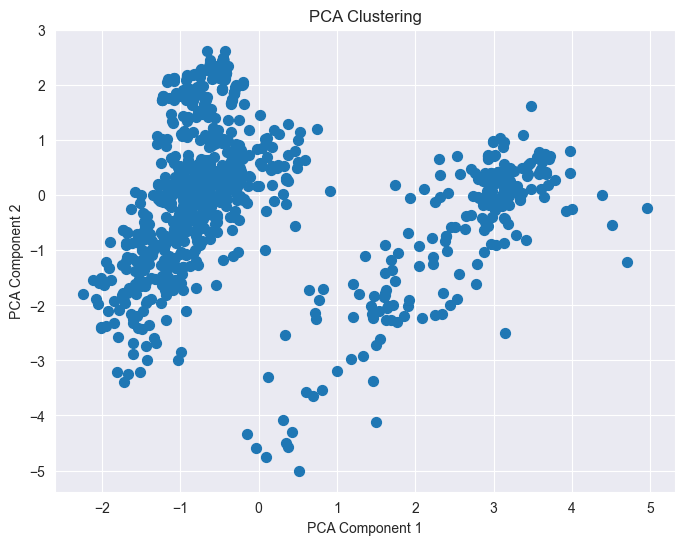

contribuiçoes de cada pca: [0.1778 0.1395 0.0986 0.0888 0.0778]


{'PCA1': {'dummy_tipo_transporte_adaptado_individual': 0.5810576475623407,
  'dummy_tipo_transporte_adaptado_transporte publico': 0.5759135986610154,
  'idade_int': 0.5037744189859688,
  'dummy_historico_obesidade_familia': 0.15932818973268525,
  'dummy_sexo': 0.12851590110916777},
 'PCA2': {'IMC': 0.5773619565323487,
  'dummy_historico_obesidade_familia': 0.38365694334650474,
  'dummy_consome_comida_calorica': 0.3431582946416198,
  'dummy_tipo_transporte_adaptado_ativo': 0.2891971423599915,
  'frequencia_atividade_fisica_int': 0.27728966628016116},
 'PCA3': {'consumo_diario_agua_int': 0.4682723833809446,
  'frequencia_atividade_fisica_int': 0.46820553912347057,
  'n_refeicoes_int': 0.4136569863369483,
  'dummy_historico_obesidade_familia': 0.36297735733485503,
  'dummy_sexo': 0.354001311366541},
 'PCA4': {'consome_vegetais_int': 0.5845256415930427,
  'dummy_sexo': 0.5097881041732062,
  'dummy_tipo_transporte_adaptado_ativo': 0.2897883640656566,
  'dummy_consome_comida_calorica': 0.282

In [579]:
pca_analysis_df, loadings, pca_contributions = pca_analysis(scaled_df, columns=numerical_columns_clustering_refinado + category_columns_clustering_refinado)

print(f"contribuiçoes de cada pca: {pca_contributions}")
loadings

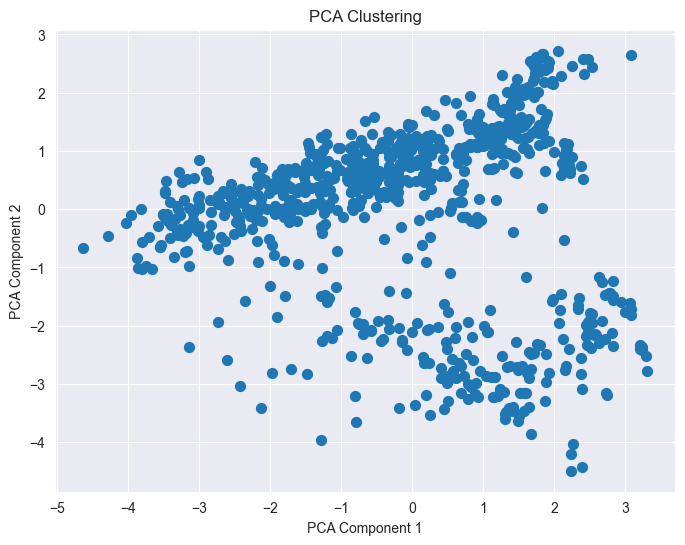

contribuiçoes de cada pca: [0.1551 0.1289 0.1065 0.0688 0.0588]


{'PCA1': {'peso': 0.49686467957419206,
  'IMC': 0.4633207007717957,
  'dummy_historico_obesidade_familia': 0.3618748922773622,
  'idade': 0.3249571227509354,
  'altura': 0.2413990295889753},
 'PCA2': {'dummy_tipo_transporte_transporte publico': 0.5572959446847489,
  'dummy_tipo_transporte_carro': 0.523177929570358,
  'idade': 0.3763445212100515,
  'peso': 0.2602479714897408,
  'IMC': 0.24479962948791986},
 'PCA3': {'altura': 0.5293409247902643,
  'dummy_sexo': 0.5030907893482064,
  'frequencia_atividade_fisica': 0.41033929510509914,
  'n_refeicoes': 0.20782626543071192,
  'consumo_diario_agua': 0.19951332396210794},
 'PCA4': {'consome_vegetais': 0.5642140816462078,
  'dummy_tipo_transporte_andando': 0.34738211531313173,
  'n_refeicoes': 0.31601581348043967,
  'dummy_consome_comida_calorica': 0.3005877148702519,
  'dummy_sexo': 0.29480826023995355},
 'PCA5': {'dummy_fuma': 0.5411657205211773,
  'dummy_tipo_transporte_bicicleta': 0.4917986483373393,
  'dummy_consome_comida_calorica': 0.4

In [580]:
pca_analysis_df, loadings, pca_contributions = pca_analysis(scaled_df, columns=numerical_columns_clustering + category_columns_clustering)

print(f"contribuiçoes de cada pca: {pca_contributions}")
loadings

Baseado no gráfico, podemos remover o último pca sem problemas.


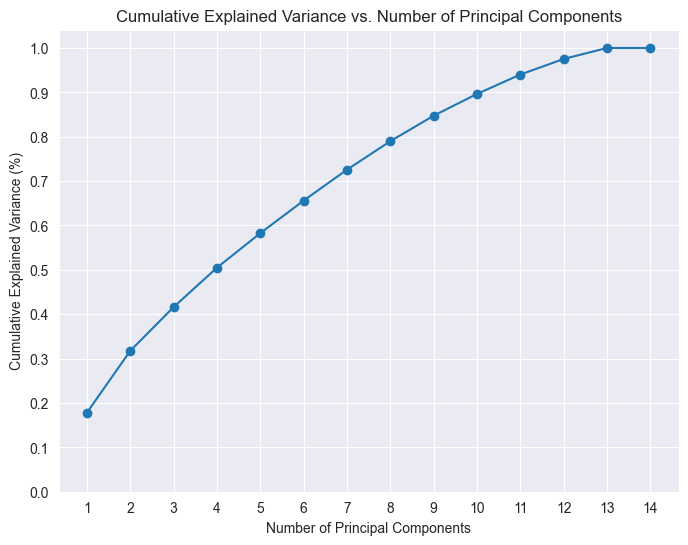

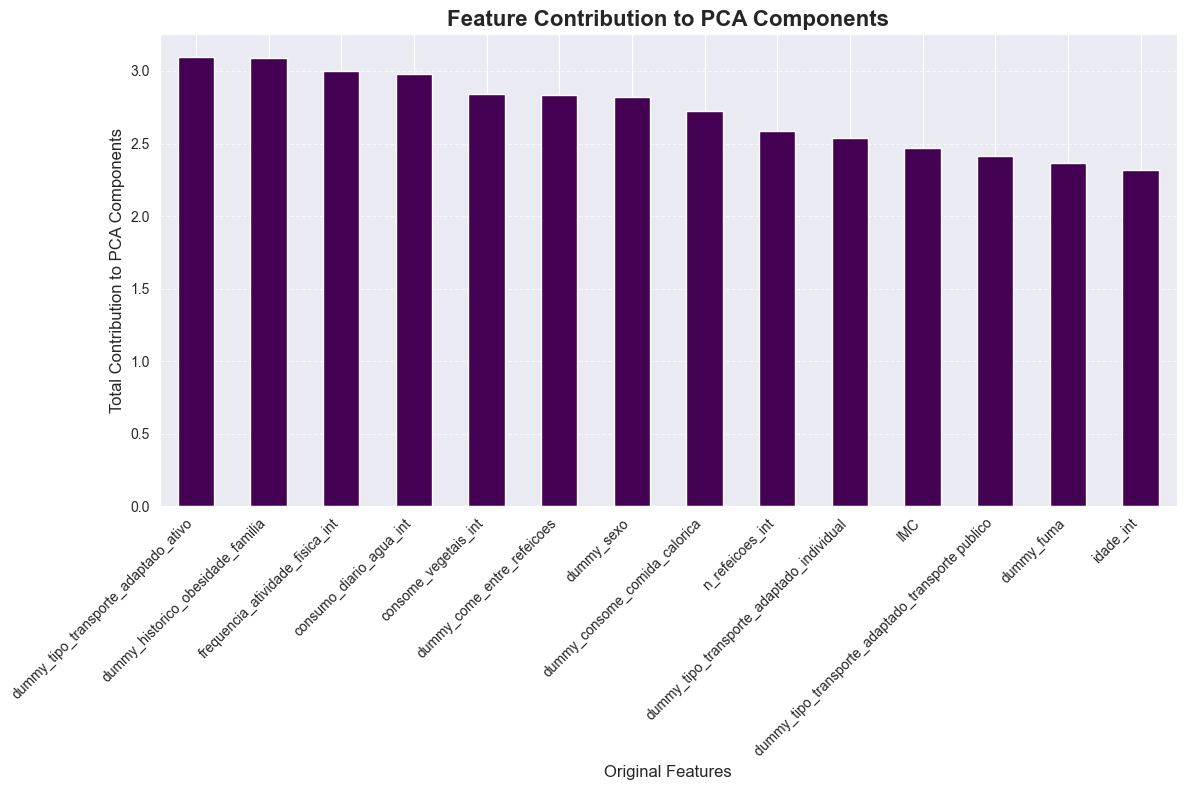

Baseado no gráfico, podemos remover o último pca sem problemas.


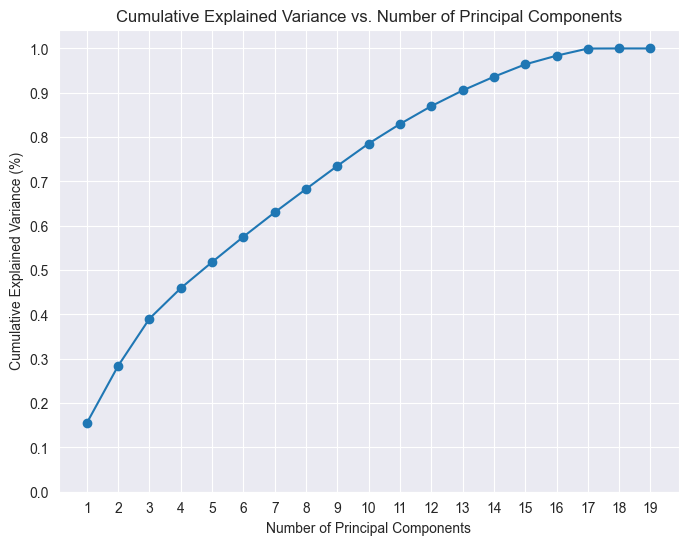

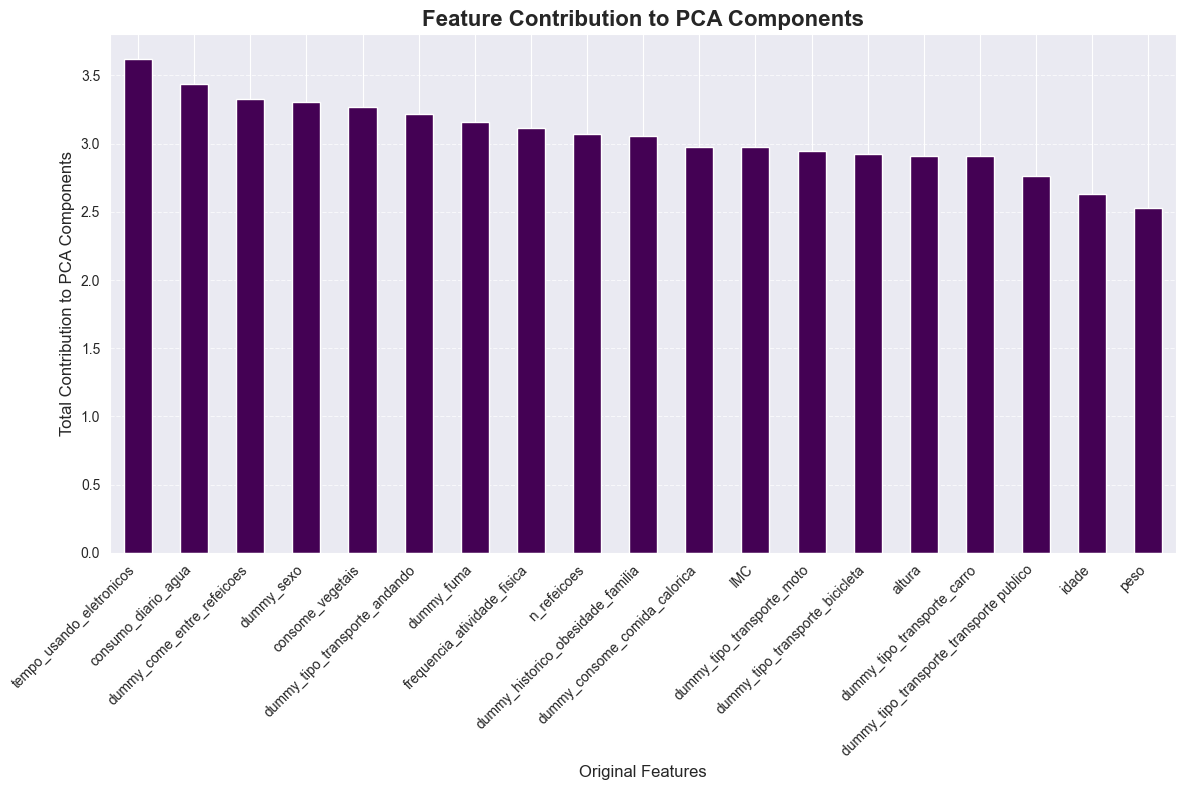

In [581]:
print("Baseado no gráfico, podemos remover o último pca sem problemas.")
cumulative_explained_variance, feature_contributions = pca_explained_variance_plot(df, columns=numerical_columns_clustering_refinado + category_columns_clustering_refinado)


print("Baseado no gráfico, podemos remover o último pca sem problemas.")
cumulative_explained_variance, feature_contributions = pca_explained_variance_plot(df, columns=numerical_columns_clustering + category_columns_clustering)

In [582]:
pca_df, loadings, pca_contributions = pca_analysis(scaled_df, columns=numerical_columns_clustering_refinado + category_columns_clustering_refinado, plot=False)

pca_df = pca_df[[f"pca{i}"for i in range(1, 14)]]
pca_df

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13
0,0.316674,0.018077,-0.320882,-1.310722,0.483345,0.114509,0.163407,1.100478,0.348991,-0.823485,-0.447139,0.587743,1.219909
1,-1.322702,-0.934568,-0.827419,-0.636354,-0.152228,-0.427961,1.851273,-2.209083,0.467287,0.119058,0.907661,0.932501,-0.443583
2,-1.559299,-1.659034,-1.954528,0.374077,0.549583,-1.272134,0.430892,1.144937,0.445932,0.425600,-0.551617,0.155614,-0.099098
3,-0.435283,2.099104,-0.375747,0.911109,0.139763,0.376627,-0.130028,0.601206,-0.133547,0.109934,0.139695,0.079507,0.018667
4,-0.524480,-0.355567,-2.842893,0.690895,-1.306078,0.372507,-0.617166,-1.360130,0.386734,0.973957,1.280358,1.528943,0.833724
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,-0.463026,2.418661,0.300000,1.109625,-0.046337,0.199782,0.301262,-0.155430,-0.652652,0.615247,0.484161,0.239172,0.088796
1092,-0.798083,-0.736399,0.141921,0.967317,1.201201,0.855946,0.499451,-2.440648,-0.019320,-3.359352,-0.566723,-0.403136,1.421553
1094,-1.563999,-1.201117,-1.859553,0.551593,0.923510,-1.256372,0.628020,2.377302,-0.188465,0.748987,0.142679,-0.097189,-0.398918
1097,0.522517,1.145200,0.179016,-1.610976,5.395129,0.530074,-3.547552,-0.774881,1.513537,0.970506,0.986600,0.529474,0.429963


# Clustering
algoritmos selecionados:
particionamento (kmeans)
hierárquica (AGNES),
densidade (optics)
grade (clique)